![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# Connectar a Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerias

In [ ]:
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

# Variables de entorno

<font color="#FF0000">Aquí definireis vuestra ruta del proyecto de perros y Gatos</font>

In [ ]:
ANCHO_IMAGEN = 150
ALTURA_IMAGEN=150
IMAGE_SIZE = (ANCHO_IMAGEN, ALTURA_IMAGEN)
CANALES_IMAGENES = 3

ruta_archivos = '/content/drive/MyDrive/00_Nuclio_DS_Master/Dogs-vs-cats/'

# Cargaremos datos en NPZ


In [ ]:
dict_npz = np.load(ruta_archivos+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

In [ ]:
x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

In [ ]:
y_train_img

array(['cat', 'cat', 'cat', ..., 'dog', 'dog', 'dog'], dtype='<U3')

# Montamos la Red Neuronal

## Cargar la parte de extraccion de features de VGG16

In [ ]:
# Creemos una red que será extracción de features basada en VGG16 entrenada con ImageNet

In [ ]:
vgg = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(150, 150,3))

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
output = vgg.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
vgg_model = Model(vgg.input, new_output_layer)

In [ ]:
vgg_model.summary() 

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [ ]:
# Veamos como va lo de "congelar" capas de entrenamiento

print(vgg_model.trainable)

True


In [ ]:
for layer in vgg_model.layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f68a62dc750> input_7 True
<keras.layers.convolutional.Conv2D object at 0x7f68390d8110> block1_conv1 True
<keras.layers.convolutional.Conv2D object at 0x7f68a62dcf50> block1_conv2 True
<keras.layers.pooling.MaxPooling2D object at 0x7f683910c4d0> block1_pool True
<keras.layers.convolutional.Conv2D object at 0x7f68390e51d0> block2_conv1 True
<keras.layers.convolutional.Conv2D object at 0x7f68a634e590> block2_conv2 True
<keras.layers.pooling.MaxPooling2D object at 0x7f68a634ae10> block2_pool True
<keras.layers.convolutional.Conv2D object at 0x7f683914ff50> block3_conv1 True
<keras.layers.convolutional.Conv2D object at 0x7f68a6338d10> block3_conv2 True
<keras.layers.convolutional.Conv2D object at 0x7f6839198110> block3_conv3 True
<keras.layers.pooling.MaxPooling2D object at 0x7f68a6343890> block3_pool True
<keras.layers.convolutional.Conv2D object at 0x7f68a6317350> block4_conv1 True
<keras.layers.convolutional.Conv2D object at 0x7f68a634a6d

In [ ]:
for layer in vgg_model.layers:
  layer.trainable = False

In [ ]:
for layer in vgg_model.layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f68a62dc750> input_7 False
<keras.layers.convolutional.Conv2D object at 0x7f68390d8110> block1_conv1 False
<keras.layers.convolutional.Conv2D object at 0x7f68a62dcf50> block1_conv2 False
<keras.layers.pooling.MaxPooling2D object at 0x7f683910c4d0> block1_pool False
<keras.layers.convolutional.Conv2D object at 0x7f68390e51d0> block2_conv1 False
<keras.layers.convolutional.Conv2D object at 0x7f68a634e590> block2_conv2 False
<keras.layers.pooling.MaxPooling2D object at 0x7f68a634ae10> block2_pool False
<keras.layers.convolutional.Conv2D object at 0x7f683914ff50> block3_conv1 False
<keras.layers.convolutional.Conv2D object at 0x7f68a6338d10> block3_conv2 False
<keras.layers.convolutional.Conv2D object at 0x7f6839198110> block3_conv3 False
<keras.layers.pooling.MaxPooling2D object at 0x7f68a6343890> block3_pool False
<keras.layers.convolutional.Conv2D object at 0x7f68a6317350> block4_conv1 False
<keras.layers.convolutional.Conv2D object at 0

## Pre-procesaremos las imagenes originales, pasandolas por VGG16, para poder usarlas en la parte de clasificacion

In [ ]:
# Llevamos las imagenes desde su origen al cuello de botella de VGG16, justo después del Flatten()
def alcuellodebotella(model, x_data):
  return model.predict(x_data)


In [ ]:
x_train_post_vgg = alcuellodebotella(vgg_model, x_train_scaled)

In [ ]:
x_test_post_vgg = alcuellodebotella(vgg_model, x_test_scaled)
x_val_post_vgg = alcuellodebotella(vgg_model, x_val_scaled)

# Montemos la red de clasificación

In [ ]:
# Definamos el output de salida de la transformacion VGG16
output_from_vgg16 = 8192 #TODO



In [ ]:
model_post_vgg = ks.Sequential()

model_post_vgg.add(ks.layers.InputLayer(input_shape=(output_from_vgg16))) 
model_post_vgg.add(ks.layers.Dense(512, activation='relu'))
model_post_vgg.add(ks.layers.Dropout(0.3))
model_post_vgg.add(ks.layers.Dense(512, activation='relu'))
model_post_vgg.add(ks.layers.Dropout(0.3))
model_post_vgg.add(ks.layers.Dense(1, activation='sigmoid'))

model_post_vgg.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 513       
                                                                 
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


# Creamos un optimizador

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
new_adam = Adam(learning_rate=0.0005)


In [ ]:
model_post_vgg.compile(loss='binary_crossentropy', optimizer=new_adam, metrics=['accuracy'])

# Early stopping!!

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=5)

# Encoding de etiquetas

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [ ]:
print(np.array(y_train_img))
print(np.array(y_train_encoded))

y_train_encoded

['cat' 'cat' 'cat' ... 'dog' 'dog' 'dog']
[0 0 0 ... 1 1 1]


array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
x_train_post_vgg.shape

(5000, 8192)

# Entrenar

In [ ]:
history = model_post_vgg.fit(x=x_train_post_vgg, y=y_train_encoded, batch_size=32,
                             epochs=10, callbacks=[callback], 
                             validation_data=(x_val_post_vgg, y_val_encoded))

Epoch 1/10
157/157 [==============================] - 4s 8ms/step - loss: 0.3792 - accuracy: 0.8278 - val_loss: 0.2244 - val_accuracy: 0.9050
Epoch 2/10
157/157 [==============================] - 1s 7ms/step - loss: 0.2434 - accuracy: 0.8988 - val_loss: 0.2432 - val_accuracy: 0.8880
Epoch 3/10
157/157 [==============================] - 1s 7ms/step - loss: 0.1908 - accuracy: 0.9182 - val_loss: 0.2215 - val_accuracy: 0.9020
Epoch 4/10
157/157 [==============================] - 1s 7ms/step - loss: 0.1603 - accuracy: 0.9364 - val_loss: 0.2190 - val_accuracy: 0.9040
Epoch 5/10
157/157 [==============================] - 1s 7ms/step - loss: 0.1292 - accuracy: 0.9478 - val_loss: 0.3371 - val_accuracy: 0.8680
Epoch 6/10
157/157 [==============================] - 1s 7ms/step - loss: 0.1055 - accuracy: 0.9568 - val_loss: 0.2933 - val_accuracy: 0.8950
Epoch 7/10
157/157 [==============================] - 1s 7ms/step - loss: 0.0882 - accuracy: 0.9638 - val_loss: 0.2480 - val_accuracy: 0.9050
Epoch 

# Guardamos el modelo

Aquí tenemos que guardar el modelo simple, pero tambien hemos de guardar, o bien el modelo de preproceso o bien los datos de test procesados en NPZ...

In [ ]:
# Modelo post VGG16
model_post_vgg.save(ruta_archivos+'model_with_basic_transfer_learning_post_vgg16.h5')

# Datos procesados de test
np.savez_compressed(ruta_archivos+'post_vgg16_test_data.npz', x=x_test_post_vgg, y=y_test_encoded)


# Miremos que tal rinde el modelo en errores y accuracy

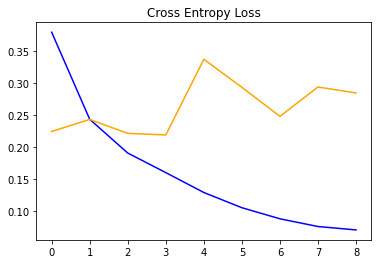

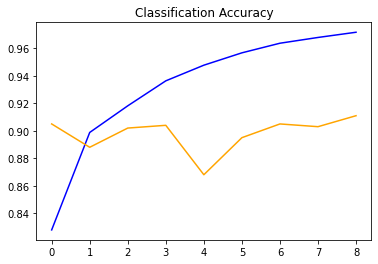

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

In [ ]:
_, acc = model_post_vgg.evaluate(x_test_post_vgg, y_test_encoded, verbose=0)
print('Modelo con Basic Transfer Learning > %.3f' % (acc * 100.0))


Modelo con Basic Transfer Learning > 90.000
